# Model Predictive Control

An entire marathon! Trying to make model predictive control (slightly more advanced than LQG) work. Main reference: https://ieeexplore-ieee-org.libproxy.berkeley.edu/stamp/stamp.jsp?tp=&arnumber=8511551

Steps:

1. Keck mirror finite-element analysis: find its $\omega_D, \omega_T, d$. Will just skip over this. 
2. Convert TF to SS and augment to make $C_i, B_i$.
3. Augment with turbulence and vibrations to make $A_i$ and $C_0$.
4. Pick $R_y, R_u, u_{max}$.
5. Solve the quadratic system!

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal, io, linalg
from cvxopt import solvers, matrix

from aberrations import *
from observer import *
from controller import *
from fractal_deriv import design_filt
from utils import *

f_sampling = 1000
rms = lambda data: np.sqrt(np.mean(data ** 2))
eps = 1e-8
process_noise = 0.01
measurement_noise = 0.06

N_delay = 2

In [2]:
# step 1: Keck mirror FEA results.

# These are completely random numbers. 

w_TT = 100
z_TT = 1

def make_impulse(w, z, T=np.arange(0, 1, 0.001)):
    num = [w**2]
    den = [1, 2 * w * z, w**2]
    tf = signal.TransferFunction(num, den)
    impulse = signal.impulse(tf, T=T)
    return impulse[0], impulse[1] / sum(impulse[1])

num, den = signal.cont2discrete(([w_TT ** 2], [1, 2 * w_TT * z_TT, w_TT ** 2]), dt=1/f_sampling)[:2]
A_TT, B_TT, C_TT, D_TT = signal.tf2ss(num, den)

/usr/local/lib/python3.7/site-packages/scipy/signal/filter_design.py:1619: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [3]:
size = 5000
N_vibe = 1
params = make_vibe_params(N=N_vibe)
vibe = make_1D_vibe_data(steps=size, N=N_vibe) + np.random.normal(0, process_noise * N_vibe, (size,))
pol = vibe
variances = np.array([process_noise] * N_vibe)
kfilter_vibe = make_kfilter_vibe(np.vstack((params[1:3])).T, variances)

Took 8 iterations to get steady-state covariance.


In [4]:
res, phy = kfilter_vibe.run(vibe + np.random.normal(0, measurement_noise, vibe.size), save_physics=True)

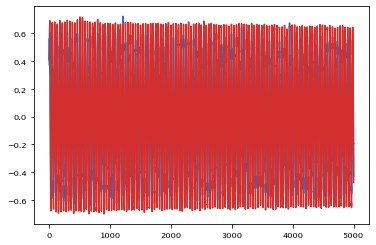

In [5]:
plt.plot(res)
plt.plot(vibe)

In [6]:
N = 2 * N_vibe + N_delay + 1

In [7]:
A = np.zeros((N, N))
for i in range(2 * N_vibe):
    for j in range(2 * N_vibe):
        A[i][j] = kfilter_vibe.A[i][j]
        
for i in range(N_vibe):
    A[2 * N_vibe][2 * i] = 1
    A[2 * N_vibe][2 * i + 1] = -1
    
A[2 * N_vibe][2 * N_vibe] = 1
for i in range(N_delay):
    A[2 * N_vibe + i + 1][2 * N_vibe + i] = 1

In [8]:
A

array([[ 1.09952002, -0.99993422,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        , -1.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ]])

In [25]:
B = np.zeros((N,1))
B[2 * N_vibe] = 1
C = np.zeros((1,N))
for i in range(N_vibe):
    C[0][2 * i] = 1
C[0][2 * N_vibe + N_delay - 1] = 1

Q = np.zeros((N,N))
for i in range(N_vibe):
    Q[2 * i][2 * i] = variances[i]

R = np.array([measurement_noise])

In [26]:
kfilter = KFilter(np.zeros(N,), A, B, Q, C, R, has_input=True)

Took 30 iterations to get steady-state covariance.


In [27]:
N_frames = 10
y, u = 5, 1
R_y = np.identity(N_frames) * y
R_u = np.identity(N_frames) * u
C_0 = np.vstack(([kfilter.H] + [kfilter.H.dot(kfilter.A ** i) for i in range(1, N_frames)]))
D_0 = np.zeros((N_frames,N_frames))
for i in range(N_frames):
    for j in range(i):
        if i - j - 1 == 0:
            D_0[i][j] = kfilter.H.dot(kfilter.B)
        else:
            D_0[i][j] = kfilter.H.dot(kfilter.A ** (i - j - 1)).dot(kfilter.B)

In [28]:
kfilter.state = np.zeros(kfilter.A.shape[0],)
H2 = 2 * kfilter.state.T.dot(C_0.T.dot(R_y).dot(D_0))
H3 = D_0.dot(R_y).dot(D_0.T) + R_u
u_max = 0.1 # float(max(np.diff(pol[:5000])))
G = np.identity(N_frames)
G = np.vstack((np.identity(N_frames), -np.identity(N_frames)))
h = np.vstack([u_max] * (2 * N_frames))

In [29]:
A

array([[ 1.09952002, -0.99993422,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        , -1.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ]])

In [30]:
solution = solvers.qp(matrix(H3), matrix(H2), matrix(G), matrix(h, tc='d'), solver='qpOASES')['x']

In [31]:
np.array(solution) # should be zero or almost zero, because the state's zero

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [32]:
kfilter.state = np.zeros(kfilter.A.shape[0],)
delay = 2

shifts = np.diff(pol)
res_control = np.zeros(pol.shape)
res_control[0] = pol[0]
actions = np.zeros(pol.shape)
for i in range(size):
    try:
        if i > 0:
            res_control[i] = res_control[i - 1] + shifts[i - 1] + actions[i - 1]
        measurement = res_control[i] + np.random.normal(0, 0.06)
        kfilter.update(measurement)
        
        if i < pol.size - N_frames - 1 and i % N_frames == 0:
            H2 = 2 * kfilter.state.T.dot(C_0.T.dot(R_y).dot(D_0))
            solvers.options['show_progress'] = False
            solution = solvers.qp(matrix(H3), matrix(H2), matrix(G), matrix(h, tc='d'), solver='cvxopt')['x']
            print(solution)
            for j in range(i, i + N_frames):
                actions[j] = solution[j - i]
        
        kfilter.predict(actions[i - 1])
        
    except:
        print(i)
        raise

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-5.00e-02]
[ 1.00e-01]
[ 1.00e-01]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 4.80e-02]
[ 1.00e-01]
[-1.00e-01]
[-1.00e-01]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[-2.61e-02]
[-1.00e-01]
[-7.84e-02]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.12e-02]
[-1.00e-01]
[ 1.00e-01]
[ 1.00e-01]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[ 8.86e-02]
[ 1.00e-01]
[ 3.27e-02]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 3.64e-02]
[ 1.00e-01]
[-1.00e-01]
[-1.00e-01]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 2.65e-02]
[-1.00e-01]
[-1.00e-01]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-3.82e-03]
[-1.00e-01]
[ 1.00e-01]
[-1.00e-01]
[ 9.70e-02]
[ 1.62e-02]

[-1.00e-01]
[-1.00e-01]
[-1.00e-

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-8.43e-02]
[-1.00e-01]
[ 1.00e-01]
[ 1.00e-01]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-2.49e-02]
[ 1.00e-01]
[ 1.00e-01]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 3.69e-02]
[ 1.00e-01]
[-1.00e-01]
[-1.00e-01]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[-3.75e-02]
[-1.00e-01]
[-7.01e-02]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[ 2.46e-02]
[-1.00e-01]
[ 1.00e-01]
[ 9.47e-02]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-9.22e-02]
[-1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 2.06e-02]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[-4.82e-02]
[ 1.00e-01]
[-1.00e-01]
[-8.03e-02]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[-1.00e-01]
[-9.99e-02]
[-2.44e-02]

[-1.00e-01]
[-1.00e-01]
[-1.00e-

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[-5.57e-02]
[-1.00e-01]
[-5.68e-02]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-7.98e-02]
[-1.00e-01]
[ 1.00e-01]
[ 1.00e-01]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[ 1.00e-01]
[ 9.99e-02]
[ 2.44e-02]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[-1.00e-01]
[-1.00e-01]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 3.61e-02]
[-1.00e-01]
[-1.00e-01]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.14e-02]
[-1.00e-01]
[ 1.00e-01]
[ 1.00e-01]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-3.21e-02]
[ 1.00e-01]
[ 1.00e-01]

[ 1.00e-01]
[ 1.00e-01]
[-1.00e-01]
[ 1.00e-01]
[-1.00e-01]
[ 1.00e-01]
[-1.00e-01]
[ 1.00e-01]
[-3.59e-02]
[-5.98e-03]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-3.62e-02]
[ 1.00e-01]
[ 1.00e-01]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.73e-03]
[ 1.00e-01]
[-1.00e-01]
[-1.00e-01]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 2.37e-02]
[-1.00e-01]
[-1.00e-01]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[ 1.84e-03]
[-1.00e-01]
[ 1.00e-01]
[ 1.00e-01]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-6.56e-03]
[ 1.00e-01]
[ 1.00e-01]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[-8.48e-02]
[ 1.00e-01]
[-1.00e-01]
[-5.81e-02]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[-8.13e-02]
[-1.00e-01]
[-3.81e-02]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-3.54e-03]
[-1.00e-01]
[ 1.00e-01]
[ 1.00e-01]

[-1.00e-01]
[-1.00e-01]
[-1.00e-

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 4.07e-02]
[-1.00e-01]
[-1.00e-01]

[ 1.00e-01]
[-1.00e-01]
[ 1.00e-01]
[-1.00e-01]
[ 1.00e-01]
[-1.00e-01]
[ 1.00e-01]
[-1.00e-01]
[ 3.59e-02]
[ 5.98e-03]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-7.07e-02]
[ 1.00e-01]
[ 1.00e-01]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 2.44e-02]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[-1.00e-01]
[-1.00e-01]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 3.72e-02]
[-1.00e-01]
[-1.00e-01]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.85e-02]
[-1.00e-01]
[ 1.00e-01]
[ 1.00e-01]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.90e-02]
[ 1.00e-01]
[ 1.00e-01]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-5.59e-02]
[ 1.00e-01]
[ 1.00e-01]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 7.38e-02]
[ 1.00e-01]
[-1.00e-01]
[-1.00e-01]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[-4.23e-02]
[-1.00e-01]
[-6.66e-02]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[ 1.32e-02]
[-1.00e-01]
[ 1.00e-01]
[ 1.00e-01]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[ 5.34e-02]
[ 1.00e-01]
[ 5.85e-02]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[-6.33e-02]
[ 1.00e-01]
[-1.00e-01]
[-7.11e-02]

[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.00e-01]
[ 1.79e-02]
[-1.00e-01]
[-1.00e-01]

[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-1.00e-01]
[-6.10e-02]
[-1.00e-01]
[ 1.00e-01]
[ 1.00e-01]

[-1.00e-01]
[-1.00e-01]
[-1.00e-

In [33]:
rms(pol[kfilter.iters:])

0.4674555772647542

In [34]:
rms(res_control[kfilter.iters:])

0.32282217793087736

(1e-10, 31.670428491310098)

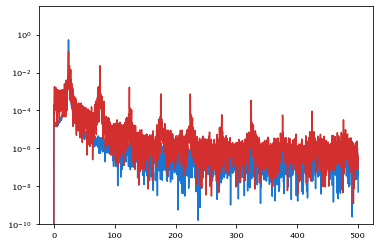

In [35]:
plt.semilogy(*signal.periodogram(pol, fs=f_sampling))
plt.semilogy(*signal.periodogram(res_control, fs=f_sampling))
# plt.semilogy(*signal.periodogram(actions, fs=f_sampling))
plt.ylim(1e-10)

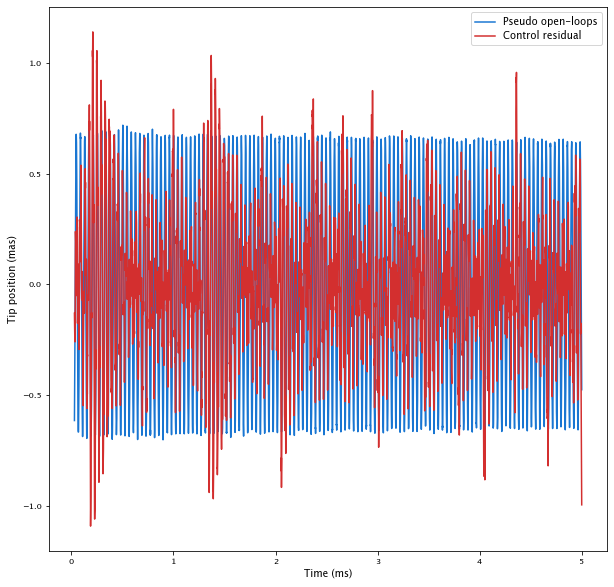

In [36]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(kfilter.iters / f_sampling, size / f_sampling, 1 / f_sampling), pol[kfilter.iters:], label='Pseudo open-loops')
plt.plot(np.arange(kfilter.iters / f_sampling, size / f_sampling, 1 / f_sampling), res_control[kfilter.iters:] - np.mean(res_control[kfilter.iters:]), label='Control residual')
plt.xlabel("Time (ms)")
plt.ylabel("Tip position (mas)")
plt.legend()
plt.show()